In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pyqubo import Binary, Array, Constraint, Placeholder
import neal

from itertools import product, permutations, combinations

np.random.seed(20)

In [2]:
# TSP problem
D = np.array([[1000, 12, 29, 22, 13, 24],
              [12, 1000, 19, 3, 25, 6],
              [29, 19, 1000, 21, 23, 28],
              [22, 3, 21, 1000, 4, 5],
              [13, 25, 23, 4, 1000, 16],
              [24, 6, 28, 5, 16, 1000]])

In [3]:
D.T == D

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

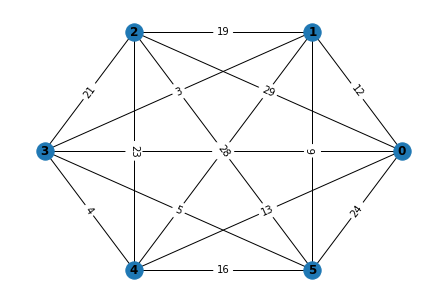

In [4]:
nodes = [i for i in range(len(D))]

G = nx.Graph()

weighted_edges = []

for i in range(len(D)):
    for j in range(i+1, len(D)):
        if i!=j:
            weighted_edges.append((nodes[i], nodes[j], D[i][j]))

G.add_weighted_edges_from(weighted_edges)

pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels= True, font_weight = 'bold')
edge_weight = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_weight)
plt.show()

In [5]:
def solve_exact(graph):
    shortest_path = list(range(len(graph))) + [0]
    min_cost = 10**5

    possible_paths = permutations(range(len(graph)))
    
    for path in possible_paths:
        cost = 0
        for i in range(len(path) - 1):
            cost = cost + graph[path[i]][path[i+1]]
        cost = cost + graph[path[-1]][path[0]]

        if cost < min_cost:
            shortest_path = list(path)
            shortest_path.append(path[0]) 
            min_cost = cost

    shortest_path = [(shortest_path[i], shortest_path[i+1]) for i in range(len(shortest_path) - 1)]
    return min_cost, shortest_path

In [6]:
optimal_cost, optimal_path = solve_exact(D)
optimal_cost, optimal_path

(76, [(0, 2), (2, 1), (1, 5), (5, 3), (3, 4), (4, 0)])

## Defining Binary variables

In [7]:
N = len(D)

X = Array.create('Q', (N, N, 3), 'BINARY')

## Writing the objective

\begin{equation}
    H_{o} = \sum_{i=0}^{N} \sum_{j=0}^{N} d_{i,j}x_{i,j,1} \;\;\; i \neq j
\end{equation}


In [8]:
objective = 0.0
path_variables = X[:,:,1]
for i in range(len(path_variables)):
    for j in range(len(path_variables[0])):
            objective += D[i][j]*path_variables[i][j]

In [9]:
objective

((1000.000000 * Binary('Q[0][0][1]')) + (12.000000 * Binary('Q[0][1][1]')) + (29.000000 * Binary('Q[0][2][1]')) + (22.000000 * Binary('Q[0][3][1]')) + (13.000000 * Binary('Q[0][4][1]')) + (24.000000 * Binary('Q[0][5][1]')) + (12.000000 * Binary('Q[1][0][1]')) + (1000.000000 * Binary('Q[1][1][1]')) + (19.000000 * Binary('Q[1][2][1]')) + (3.000000 * Binary('Q[1][3][1]')) + (25.000000 * Binary('Q[1][4][1]')) + (6.000000 * Binary('Q[1][5][1]')) + (29.000000 * Binary('Q[2][0][1]')) + (19.000000 * Binary('Q[2][1][1]')) + (1000.000000 * Binary('Q[2][2][1]')) + (21.000000 * Binary('Q[2][3][1]')) + (23.000000 * Binary('Q[2][4][1]')) + (28.000000 * Binary('Q[2][5][1]')) + (22.000000 * Binary('Q[3][0][1]')) + (3.000000 * Binary('Q[3][1][1]')) + (21.000000 * Binary('Q[3][2][1]')) + (1000.000000 * Binary('Q[3][3][1]')) + (4.000000 * Binary('Q[3][4][1]')) + (5.000000 * Binary('Q[3][5][1]')) + (13.000000 * Binary('Q[4][0][1]')) + (25.000000 * Binary('Q[4][1][1]')) + (23.000000 * Binary('Q[4][2][1]'))

## Writing the Constraints

### Constraint 1
The edge between nodes i and j can either belong to path, or not belong to it.
  
$$
    \forall \, i,j : H_{c1} = (\sum_{r=0}^{2} \, x_{i,j,r} - 1)^{2}
$$

In [10]:
c1 = 0.0
for i in range(N):
    for j in range(N):
        if i!= j:
            c1 += Constraint((sum(X[i][j]) - 1)**2, label="c1{}{}".format(i,j))

### Constraint 2
The salesman must exit every node only once.
  
$$
    \forall \, i : H_{c2} = (\sum_{j=0}^{N} \, x_{i,j,1} - 1)^{2}
$$

In [11]:
c2 = 0.0
for i in range(N):
    c2 += Constraint((sum(X[i][:,1]) - 1)**2, label="c2{}{}".format(i,j))

### Constraint 3
The salesman must enter every node only once.
  
$$
    \forall \, j : H_{c3} = (\sum_{i=0}^{N} \, x_{i,j,1} - 1)^{2}
$$

In [12]:
c3 = 0.0
for j in range(N):
    c3 += Constraint((sum(X[:,j][:,1]) - 1)**2, label="c3{}{}".format(i,j))

### Constraint 4
If node $i$ is reached before $j$, then node $j$ is reached after $i$. So, $\forall i,j \in {0,..,N}$ such that $ i \neq j$
  
$$
    x_{i,j,2} = 1 - x_{j, i, 2}
$$

In [13]:
c4 = 0.0
for i in range(N):
    for j in range(N):
        if i!=j:
            c4 += Constraint((X[i][j][2] - 1 + X[j][i][2])**2, label="c4{}{}".format(i,j))

### Constraint 5
If node $i$ is reached before $j$ and node $j$ is reached before node $k$, then node $i$ must be reached before $k$. This condition will prevent the route from returning to a node from which it had aleady exited, thus preventing cycles from forming. It is implemented as a penalty term - 

$$
    \sum_{i=1}^{N} \sum_{j=1}^{N} \sum_{k=1}^{N} (x_{j,i,2}x_{k,j,2} - x_{j,i,2}x_{k,i,2} - x_{k,j,2}x_{k,i,2} + x_{k,i,2}) 
$$

Only cases in which $i \neq j$ and $j \neq k$ and $i \neq k$ are considered.

In [14]:
c5 = 0.0
for i in range(1, N):
    for j in range(1, N):
        for k in range(1, N):
            if i!=j and j!=k and i!=k:
                c5 += (X[j][i][2]*X[k][j][2] - X[j][i][2]*X[k][i][2] - X[k][j][2]*X[k][i][2] + X[k][i][2])



## Defining the total Hamiltonian

In [15]:
A = Placeholder("A")
P = Placeholder("P")

H = objective + A*(c1 + c2 + c3 + c4)

H = H + P*c5

## Compile the model and convert to a BinaryQuadraticModel

_**A**_ and _**P**_ values are selected as $75 \%$ to $150 \%$ of optimal cost.

In [30]:
model = H.compile()

feed_dict = {"A": 100, "P": 110}
bqm = model.to_bqm(feed_dict = feed_dict)

## Run Simulated Annealing

In [31]:
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=100, num_sweeps=100)

## Decode results

In [32]:
decoded_samples = model.decode_sampleset(sampleset, feed_dict=feed_dict)
best_sample = min(decoded_samples, key = lambda x: x.energy)
num_broken = len(best_sample.constraints(only_broken = True))
num_broken

0

In [33]:
[decoded_samples]

In [19]:
sample = best_sample.sample
solution = []
for k in sample:
    if sample[k] == 1:
        solution.append(k)

final_solution = []
for kstring in solution:
    if kstring[-2] == '1':
        final_solution.append(kstring)

In [20]:
import re

def parse_path(result):
    edges = {}
    for element in result:
        numbers = re.findall("\[\d*\]", element)
        start, end = tuple(map(lambda x: int(x[1:-1]), numbers[:2]))
        edges[start] = end
    
    path = [(0, edges[0])]
    next = edges[0]

    while next != 0:
        path.append((next, edges[next]))
        next = edges[next]

    return path
            
path_to_plot = parse_path(final_solution)
print('SA solution: {}, SA cost: {}'.format(path_to_plot, best_sample.energy))
print('Exact solution: {}, Optimal cost: {}'.format(optimal_path, optimal_cost))

SA solution: [(0, 2), (2, 1), (1, 5), (5, 3), (3, 4), (4, 0)], SA cost: 76.0
Exact solution: [(0, 2), (2, 1), (1, 5), (5, 3), (3, 4), (4, 0)], Optimal cost: 76


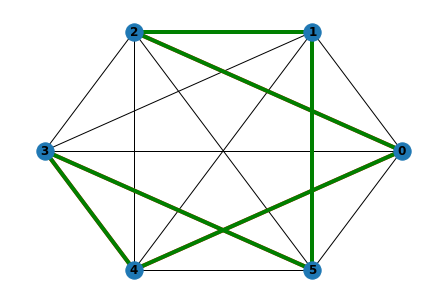

In [21]:
nx.draw(G, pos, with_labels = True, font_weight = 'bold')
nx.draw_networkx_edges(G, pos, edgelist=path_to_plot, edge_color='r', width=4)
nx.draw_networkx_edges(G, pos, edgelist=optimal_path, edge_color='g', width=4)
plt.show()

## Run Simulated Annealing with changing parameter value

In [22]:
def run_sa(model, parameter_list, verbose=1):
    history = []

    for parameter in parameter_list:
        parameter = round(parameter, 2)
        feed_dict = {"A": parameter, "P": parameter}
        bqm = model.to_bqm(feed_dict = feed_dict)
        
        sa = neal.SimulatedAnnealingSampler()
        sampleset = sa.sample(bqm, num_reads=100, num_sweeps=100)

        decoded_samples = model.decode_sampleset(sampleset, feed_dict=feed_dict)
        best_sample = min(decoded_samples, key = lambda x: x.energy)
        num_broken = len(best_sample.constraints(only_broken = True))
        if num_broken != 0:
            print("Constraints not satisfied for parameter {:.2f}".format(parameter))
        
        cost = best_sample.energy
        history.append(cost)

        if verbose:
            print("Parameter {:.2f} Cost {:.2f}".format(parameter, cost))
    
    return history

In [28]:
parameter_list = np.linspace(optimal_cost - 0.75*optimal_cost, optimal_cost + 1.5*optimal_cost, num=50)

history = run_sa(model, parameter_list, verbose=0)

Constraints not satisfied for parameter 19.00


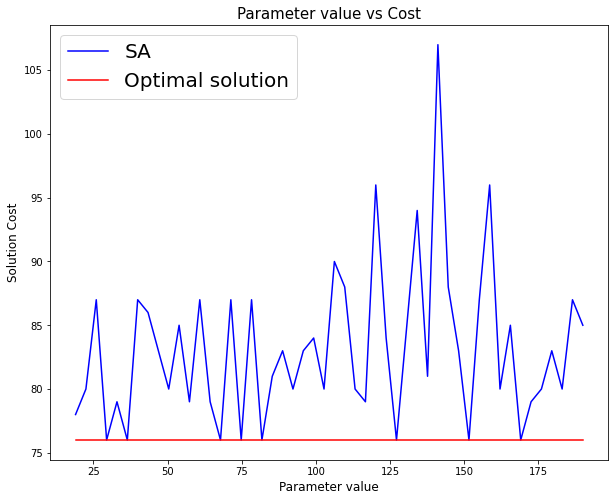

In [29]:
plt.figure(figsize=(10,8))
plt.plot(parameter_list, history, color = 'b', label='SA')
plt.xlabel("Parameter value", fontsize=12)
plt.ylabel("Solution Cost", fontsize=12)
plt.plot(parameter_list, [optimal_cost for _ in range(len(parameter_list))], color='r', label='Optimal solution')
plt.title("Parameter value vs Cost", fontsize=15)
plt.legend(fontsize=20)
plt.show()

# Number of qubits required = $3N^{2}$
---